# CS156 - Pipeline - First Draft
## Which video will I like?

### Problem definition


### Section 2: Converting data into Python dataframe

In [51]:
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

# Set up OAuth 2.0 authentication flow
scopes = ["https://www.googleapis.com/auth/youtube.force-ssl"]
client_secrets_file = "../../../Desktop/client_secret.json"

# Create an OAuth flow and get credentials using the local server method
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
    client_secrets_file, scopes)

# Use run_local_server() to initiate the OAuth flow
flow.redirect_uri = 'http://localhost:5001/oauth2callback'
credentials = flow.run_local_server(port=5001)

# Create a YouTube client
youtube = googleapiclient.discovery.build("youtube", "v3", credentials=credentials)


# Request liked videos
request = youtube.videos().list(
    part="snippet,contentDetails",
    myRating="like"
)
response = request.execute()

# Process and print video details
for item in response.get("items", []):
    title = item["snippet"]["title"]
    video_id = item["id"]
    print(f"Title: {title}, Video ID: {video_id}")


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=217986578119-0l6jjn9u267th7o7rh7bm2uqffaqqq96.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A5001%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=rf8n0Btx7nFq7Is7dG9GrKRC83spM3&access_type=offline
Title: 개발자 취업, 100% 성공하는 포트폴리오 작성법, Video ID: aV1GcmMh-ME
Title: What Is Dynamic Programming and How To Use It, Video ID: vYquumk4nWw
Title: 8 vs. 8 soccer: Tactics, Formation, Position (3-3-1), Video ID: iUPthkBfjJM
Title: 만능 반찬 소고기소보루 레시피 🐮, Video ID: JzEt1rvl8EA
Title: 이무진 신곡 스포 멜로디만 보고 코드 맞추기, Video ID: F4pXf_KIYu4


  category                                              title  \
0    Liked                        개발자 취업, 100% 성공하는 포트폴리오 작성법   
1    Liked      What Is Dynamic Programming and How To Use It   
2    Liked  8 vs. 8 soccer: Tactics, Formation, Position (...   
3    Liked                                 만능 반찬 소고기소보루 레시피 🐮   
4    Liked                           이무진 신곡 스포 멜로디만 보고 코드 맞추기   

                                         description  \
0  #개발자취업 #코딩공부 #개발자면접 #개발자포트폴리오 #개발자공부 #개발자이력서\n...   
1  **Dynamic Programming Tutorial**\nThis is a qu...   
2  This video looks at three of the basics for an...   
3                                                      
4  #이무진 #청춘만화 #라디오스타 #노래 #음악 #피아노 #기타 \n#Sofa4844...   

                                                tags category_id  duration  \
0  [#개발자취엽, #개발자취없, #개발자치업, #개발자치엽, #개발자취엡, #코딩궁부...          26  PT14M11S   
1  [dynamic programming tutorial, dynamic program...          27  PT14M28S   
2  [soocer, U9, coaching, 3-3-1- forma

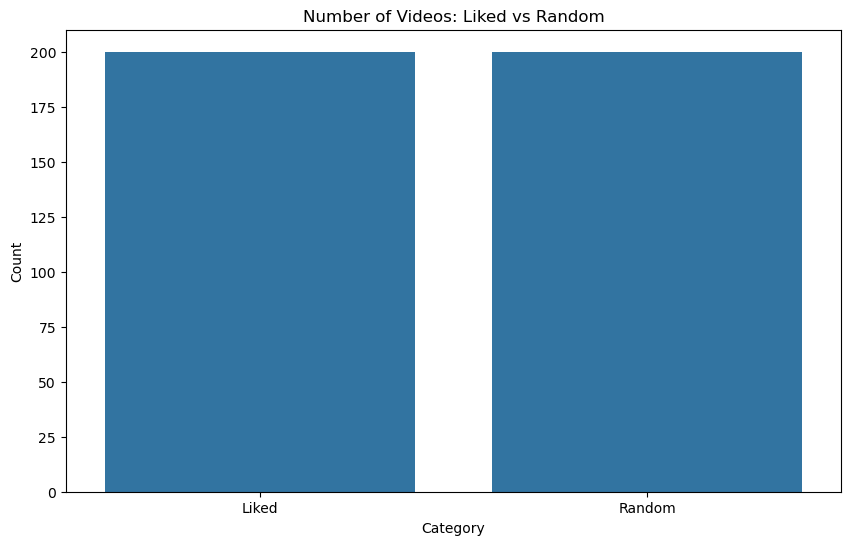

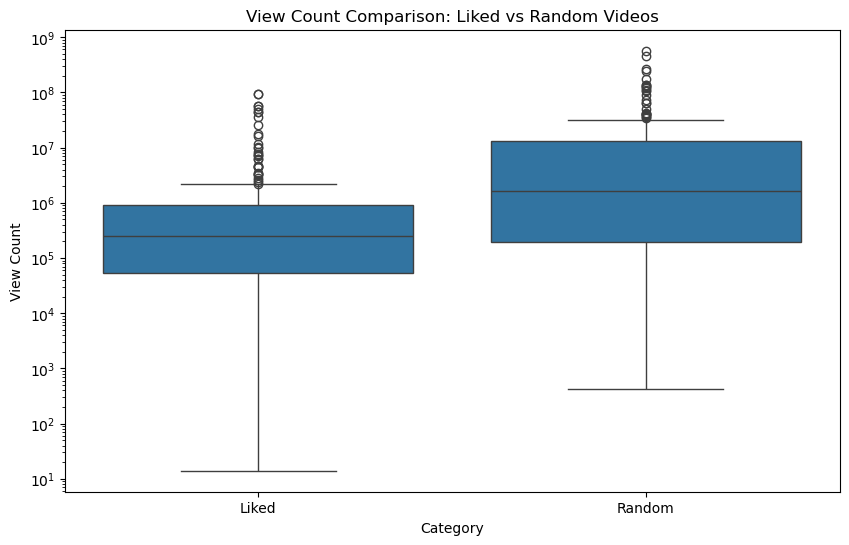

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_liked_videos(max_results=200):
    videos = []
    next_page_token = None

    while len(videos) < max_results:
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,topicDetails",
            myRating="like",
            maxResults=50,
            pageToken=next_page_token
        )

        response = request.execute()
        videos.extend(response.get("items", []))

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    return videos[:max_results]

def get_random_videos_details(video_ids):
    videos = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,topicDetails",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        videos.extend(response.get("items", []))
    return videos

def get_random_videos(max_results=200, regions=['US', 'KR']):
    search_terms = ["music", "technology", "news", "sports", "gaming", "cooking", "travel", "science"]
    video_ids = []

    for term in search_terms:
        if len(video_ids) >= max_results:
            break

        for region in regions:
            request = youtube.search().list(
                part="snippet",
                q=term,
                type="video",
                maxResults=25,  # Reduce max results to balance between regions
                regionCode=region
            )

            response = request.execute()
            video_ids.extend([item['id']['videoId'] for item in response.get("items", [])])

            if len(video_ids) >= max_results:
                break

    return get_random_videos_details(video_ids[:max_results])

# Get 200 liked videos
liked_videos = get_liked_videos(max_results=200)

# Get 200 random videos from YouTube (from US and Korea)
random_videos = get_random_videos(max_results=200, regions=['US', 'KR'])

# Create DataFrame to store video information
def create_dataframe(video_items, category):
    data = []
    for item in video_items:
        snippet = item.get("snippet", {})
        content_details = item.get("contentDetails", {})
        statistics = item.get("statistics", {})
        topic_details = item.get("topicDetails", {})

        video_info = {
            "category": category,
            "title": snippet.get("title", "N/A"),
            "description": snippet.get("description", "N/A"),
            "tags": snippet.get("tags", "N/A"),
            "category_id": snippet.get("categoryId", "N/A"),
            "duration": content_details.get("duration", "N/A"),
            "view_count": int(statistics.get("viewCount", 0)),
            "like_count": int(statistics.get("likeCount", 0)),
            "comment_count": int(statistics.get("commentCount", 0)),
            "topic_categories": topic_details.get("topicCategories", "N/A"),
            "language": snippet.get("defaultAudioLanguage", snippet.get("defaultLanguage", "N/A"))
        }
        data.append(video_info)
    return pd.DataFrame(data)

# Create DataFrames for liked and random videos
liked_videos_df = create_dataframe(liked_videos, "Liked")
random_videos_df = create_dataframe(random_videos, "Random")

# Combine both DataFrames
combined_df = pd.concat([liked_videos_df, random_videos_df], ignore_index=True)

# Save DataFrame to CSV
combined_df.to_csv("combined_videos.csv", index=False)

# Display the DataFrame
print(combined_df.head())

# Summarize the dataset
print("\nDataset Summary:")
print(combined_df.describe())

# Bar graph to compare number of liked and random videos
plt.figure(figsize=(10, 6))
sns.countplot(x="category", data=combined_df)
plt.title("Number of Videos: Liked vs Random")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Compare views of liked and random videos
plt.figure(figsize=(10, 6))
sns.boxplot(x="category", y="view_count", data=combined_df)
plt.title("View Count Comparison: Liked vs Random Videos")
plt.xlabel("Category")
plt.ylabel("View Count")
plt.yscale("log")  # Use log scale to handle wide range of view counts
plt.show()


  category                                              title  \
0    Liked                        개발자 취업, 100% 성공하는 포트폴리오 작성법   
1    Liked      What Is Dynamic Programming and How To Use It   
2    Liked  8 vs. 8 soccer: Tactics, Formation, Position (...   
3    Liked                                 만능 반찬 소고기소보루 레시피 🐮   
4    Liked                           이무진 신곡 스포 멜로디만 보고 코드 맞추기   

                                         description  \
0  #개발자취업 #코딩공부 #개발자면접 #개발자포트폴리오 #개발자공부 #개발자이력서\n...   
1  **Dynamic Programming Tutorial**\nThis is a qu...   
2  This video looks at three of the basics for an...   
3                                                      
4  #이무진 #청춘만화 #라디오스타 #노래 #음악 #피아노 #기타 \n#Sofa4844...   

                                                tags category_id  duration  \
0  [#개발자취엽, #개발자취없, #개발자치업, #개발자치엽, #개발자취엡, #코딩궁부...          26  PT14M11S   
1  [dynamic programming tutorial, dynamic program...          27  PT14M28S   
2  [soocer, U9, coaching, 3-3-1- forma

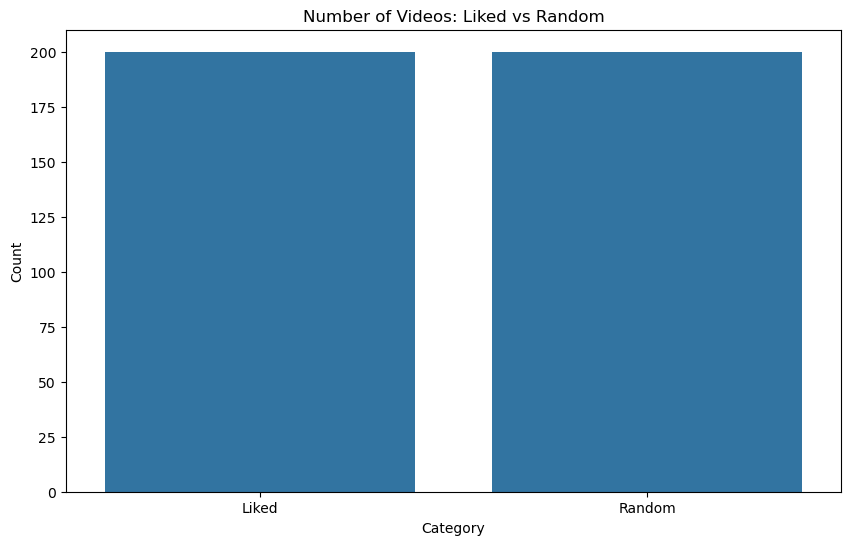

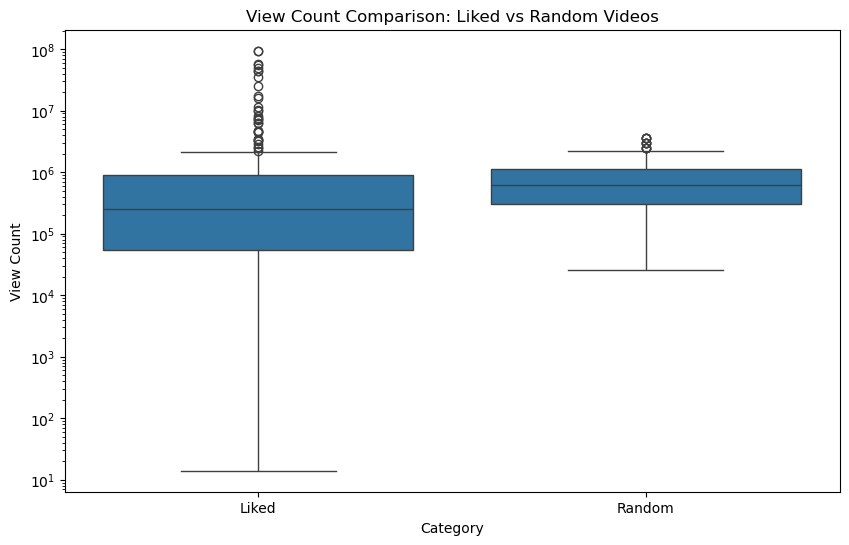

In [48]:

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


def get_liked_videos(max_results=200):
    videos = []
    next_page_token = None

    while len(videos) < max_results:
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,topicDetails",
            myRating="like",
            maxResults=50,
            pageToken=next_page_token
        )

        response = request.execute()
        videos.extend(response.get("items", []))

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    return videos[:max_results]

def get_random_videos_details(video_ids):
    videos = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,topicDetails",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        videos.extend(response.get("items", []))
    return videos

def get_random_videos(max_results=200, regions=['US', 'KR']):
    video_ids = []

    for region in regions:
        while len(video_ids) < max_results:
            request = youtube.videos().list(
                part="snippet",
                chart="mostPopular",
                regionCode=region,
                maxResults=50
            )

            response = request.execute()
            video_ids.extend([item['id'] for item in response.get("items", [])])

            if len(video_ids) >= max_results:
                break

    return get_random_videos_details(video_ids[:max_results])

# Get 200 liked videos
liked_videos = get_liked_videos(max_results=200)

# Get 200 random videos from YouTube (from US and Korea)
random_videos = get_random_videos(max_results=200, regions=['US', 'KR'])

# Create DataFrame to store video information
def create_dataframe(video_items, category):
    data = []
    for item in video_items:
        snippet = item.get("snippet", {})
        content_details = item.get("contentDetails", {})
        statistics = item.get("statistics", {})
        topic_details = item.get("topicDetails", {})

        video_info = {
            "category": category,
            "title": snippet.get("title", "N/A"),
            "description": snippet.get("description", "N/A"),
            "tags": snippet.get("tags", "N/A"),
            "category_id": snippet.get("categoryId", "N/A"),
            "duration": content_details.get("duration", "N/A"),
            "view_count": int(statistics.get("viewCount", 0)),
            "like_count": int(statistics.get("likeCount", 0)),
            "comment_count": int(statistics.get("commentCount", 0)),
            "topic_categories": topic_details.get("topicCategories", "N/A"),
            "language": snippet.get("defaultAudioLanguage", snippet.get("defaultLanguage", "N/A"))
        }
        data.append(video_info)
    return pd.DataFrame(data)

# Create DataFrames for liked and random videos
liked_videos_df = create_dataframe(liked_videos, "Liked")
random_videos_df = create_dataframe(random_videos, "Random")

# Combine both DataFrames
combined_df = pd.concat([liked_videos_df, random_videos_df], ignore_index=True)

# Save DataFrame to CSV
combined_df.to_csv("combined_videos.csv", index=False)

# Display the DataFrame
print(combined_df.head())

# Summarize the dataset
print("\nDataset Summary:")
print(combined_df.describe())

# Bar graph to compare number of liked and random videos
plt.figure(figsize=(10, 6))
sns.countplot(x="category", data=combined_df)
plt.title("Number of Videos: Liked vs Random")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Compare views of liked and random videos
plt.figure(figsize=(10, 6))
sns.boxplot(x="category", y="view_count", data=combined_df)
plt.title("View Count Comparison: Liked vs Random Videos")
plt.xlabel("Category")
plt.ylabel("View Count")
plt.yscale("log")  # Use log scale to handle wide range of view counts
plt.show()


  category                                              title  \
0    Liked                        개발자 취업, 100% 성공하는 포트폴리오 작성법   
1    Liked      What Is Dynamic Programming and How To Use It   
2    Liked  8 vs. 8 soccer: Tactics, Formation, Position (...   
3    Liked                                 만능 반찬 소고기소보루 레시피 🐮   
4    Liked                           이무진 신곡 스포 멜로디만 보고 코드 맞추기   

                                         description  \
0  #개발자취업 #코딩공부 #개발자면접 #개발자포트폴리오 #개발자공부 #개발자이력서\n...   
1  **Dynamic Programming Tutorial**\nThis is a qu...   
2  This video looks at three of the basics for an...   
3                                                      
4  #이무진 #청춘만화 #라디오스타 #노래 #음악 #피아노 #기타 \n#Sofa4844...   

                                                tags category_id  duration  \
0  [#개발자취엽, #개발자취없, #개발자치업, #개발자치엽, #개발자취엡, #코딩궁부...          26  PT14M11S   
1  [dynamic programming tutorial, dynamic program...          27  PT14M28S   
2  [soocer, U9, coaching, 3-3-1- forma

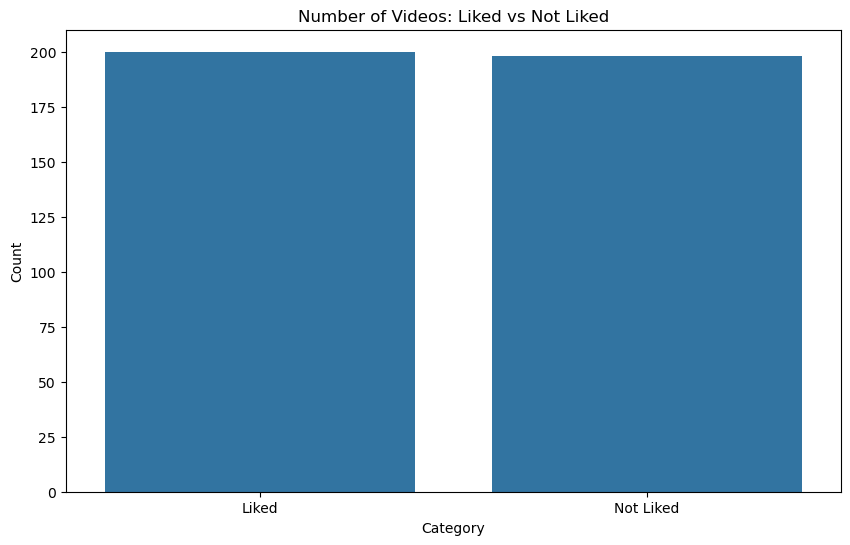

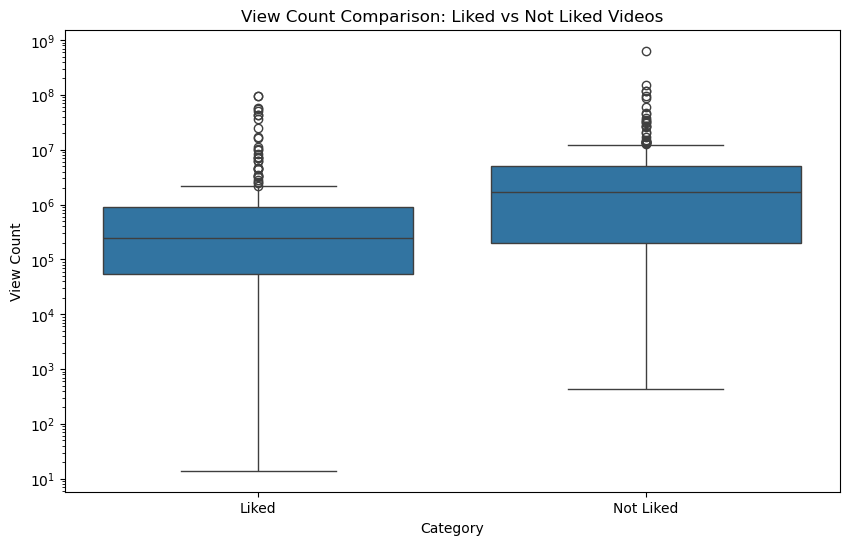

In [58]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import random

def get_liked_videos(max_results=200):
    videos = []
    next_page_token = None

    while len(videos) < max_results:
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics,topicDetails",
            myRating="like",
            maxResults=50,
            pageToken=next_page_token
        )

        response = request.execute()
        videos.extend(response.get("items", []))

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    return videos[:max_results]

def get_random_videos_details(video_ids):
    videos = []
    for i in range(0, len(video_ids), 50):
        try:
            request = youtube.videos().list(
                part="snippet,contentDetails,statistics,topicDetails",
                id=','.join(video_ids[i:i+50])
            )
            response = request.execute()
            videos.extend(response.get("items", []))
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
    return videos

def get_recently_watched_videos_from_html(file_path, max_results=1000):
    # Read the HTML file
    with open(file_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f, 'lxml')

    # Find all watch history entries
    entries = soup.find_all('div', class_='mdl-grid')

    video_ids = []
    for entry in entries:
        # Find the anchor tag with the video URL
        a_tag = entry.find('a')
        if a_tag and 'youtube.com/watch' in a_tag.get('href', ''):
            url = a_tag['href']
            # Extract the video ID using regex
            match = re.search(r'v=([^&]+)', url)
            if match:
                video_id = match.group(1)
                video_ids.append(video_id)
                if len(video_ids) >= max_results:
                    break

    # Remove duplicates while preserving order
    video_ids = list(dict.fromkeys(video_ids))

    return video_ids

def create_dataframe(video_items, category):
    data = []
    for item in video_items:
        snippet = item.get("snippet", {})
        content_details = item.get("contentDetails", {})
        statistics = item.get("statistics", {})
        topic_details = item.get("topicDetails", {})

        video_info = {
            "category": category,
            "title": snippet.get("title", "N/A"),
            "description": snippet.get("description", "N/A"),
            "tags": snippet.get("tags", "N/A"),
            "category_id": snippet.get("categoryId", "N/A"),
            "duration": content_details.get("duration", "N/A"),
            "view_count": int(statistics.get("viewCount", 0)),
            "like_count": int(statistics.get("likeCount", 0)),
            "comment_count": int(statistics.get("commentCount", 0)),
            "topic_categories": topic_details.get("topicCategories", "N/A"),
            "language": snippet.get("defaultAudioLanguage", snippet.get("defaultLanguage", "N/A"))
        }
        data.append(video_info)
    return pd.DataFrame(data)

# Provide the path to your watch-history.html file
file_path = '/Users/hcoh/Downloads/Takeout 3/YouTube and YouTube Music/history/watch-history.html'

# Get 200 liked videos
liked_videos = get_liked_videos(max_results=200)

# Extract liked video IDs
liked_video_ids = [item['id'] for item in liked_videos]

# Get 1000 recently watched video IDs
recently_watched_video_ids = get_recently_watched_videos_from_html(file_path, max_results=1000)

# Filter out liked videos
unliked_video_ids = [vid for vid in recently_watched_video_ids if vid not in liked_video_ids]

# Ensure we have enough videos to sample from
if len(unliked_video_ids) < 200:
    print("Not enough unliked videos to sample from.")
    # Use all available videos
    unliked_sample_ids = unliked_video_ids
else:
    unliked_sample_ids = random.sample(unliked_video_ids, 200)

# Fetch details of the unliked sampled videos
unliked_videos = get_random_videos_details(unliked_sample_ids)

# Create DataFrames for liked and unliked videos
liked_videos_df = create_dataframe(liked_videos, "Liked")
unliked_videos_df = create_dataframe(unliked_videos, "Not Liked")

# Combine both DataFrames
combined_df = pd.concat([liked_videos_df, unliked_videos_df], ignore_index=True)

# Save DataFrame to CSV
combined_df.to_csv("combined_videos.csv", index=False)

# Display the DataFrame
print(combined_df.head())

# Summarize the dataset
print("\nDataset Summary:")
print(combined_df.describe())

# Bar graph to compare number of liked and unliked videos
plt.figure(figsize=(10, 6))
sns.countplot(x="category", data=combined_df)
plt.title("Number of Videos: Liked vs Not Liked")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Compare views of liked and unliked videos
plt.figure(figsize=(10, 6))
sns.boxplot(x="category", y="view_count", data=combined_df)
plt.title("View Count Comparison: Liked vs Not Liked Videos")
plt.xlabel("Category")
plt.ylabel("View Count")
plt.yscale("log")  # Use log scale to handle wide range of view counts
plt.show()


In [59]:
combined_df

,category,title,description,tags,category_id,duration,view_count,like_count,comment_count,topic_categories,language
0,Liked,"개발자 취업, 100% 성공하는 포트폴리오 작성법",#개발자취업 #코딩공부 #개발자면접 #개발자포트폴리오 #개발자공부 #개발자이력서\n...,"[#개발자취엽, #개발자취없, #개발자치업, #개발자치엽, #개발자취엡, #코딩궁부...",26,PT14M11S,132,16,7,[https://en.wikipedia.org/wiki/Knowledge],ko
1,Liked,What Is Dynamic Programming and How To Use It,**Dynamic Programming Tutorial**\nThis is a qu...,"[dynamic programming tutorial, dynamic program...",27,PT14M28S,1606381,41525,1619,[https://en.wikipedia.org/wiki/Knowledge],en
2,Liked,"8 vs. 8 soccer: Tactics, Formation, Position (...",This video looks at three of the basics for an...,"[soocer, U9, coaching, 3-3-1- formation, kid-f...",22,PT7M20S,85312,1167,23,[https://en.wikipedia.org/wiki/Association_foo...,N/A
3,Liked,만능 반찬 소고기소보루 레시피 🐮,,N/A,22,PT28S,58821,986,15,[https://en.wikipedia.org/wiki/Food],N/A
4,Liked,이무진 신곡 스포 멜로디만 보고 코드 맞추기,#이무진 #청춘만화 #라디오스타 #노래 #음악 #피아노 #기타 \n#Sofa4844...,"[Sofa4844, Shorts, 음악, 노래, 피아노, 이무진, 신호등, 청춘만화...",10,PT29S,1583061,28959,1270,"[https://en.wikipedia.org/wiki/Music, https://...",ko
...,...,...,...,...,...,...,...,...,...,...,...
393,Not Liked,교수님한테까지 유출된 에타의 비밀,공감과 정보와 추억을 모두 담은\n캠퍼스 문화 부흥 프로젝트\n\n📚 매일 전과하는...,"[오오디디, 오오티디, ootd, oodf, ootv, 전가자, 전까자, 전꽈, 전...",24,PT1M,3294142,75574,413,"[https://en.wikipedia.org/wiki/Entertainment, ...",ko
394,Not Liked,광야를 지나며,Provided to YouTube by Kwangsoo Media\n\n광야를 지...,"[히즈윌(HisWill), 살아가다, 광야를 지나며]",10,PT4M58S,1946404,4461,0,[https://en.wikipedia.org/wiki/Christian_music...,N/A
395,Not Liked,Crazy? Silicon Valley Software Engineer living...,I have been living in my car for the past 6 mo...,N/A,22,PT7M9S,517509,10414,1425,[https://en.wikipedia.org/wiki/Lifestyle_(soci...,en-US
396,Not Liked,길 (Ghil_Path),Provided to YouTube by Collab Asia Music\n\n길 ...,"[LEVISTANCE, 길, 길 (Ghil_Path)]",10,PT4M55S,111208,807,5,[https://en.wikipedia.org/wiki/Christian_music...,N/A
